#  AI for practitioners

## Supervised Learning [Random Forest](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) [sklearn]

One limitation of the decision tree was that small deviations in data can result in very different models that may overfit the data. The random forest is an ensemble (or meta) learner that fits a number of decision tree classifiers on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting..

### Advantages
------------------------------------------------------------
- Less prone to overfitting the data (better predictive ability)
- Can deal with both numerical and categorical data

### Disadvantages
------------------------------------------------------------
- More difficult to understand / interpret the models, because there are many decision trees


### The parameters include
------------------------------------------------------------
- The number of estimators (trees)
- Max depth of a tree (low values may overfit data, high values may underfit data)
- Minimum samples in a leaf node of a tree ( low values may overfit data, high values may underfit data)

In [1]:
%matplotlib inline
import os

import numpy as np
import pandas as pd
import csv

from sklearn.model_selection import cross_val_score
from sklearn.datasets import make_blobs
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier

import matplotlib as mpl
import matplotlib.pyplot as plt

## comment out if you dont have it installed, but visualizing tree is not possible then
import graphviz
from graphviz import Source
#os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'

In [2]:
# bigger plits
plt.rcParams['figure.figsize'] = [20, 15]

# Plot the decision surfaces of ensembles of trees on the iris dataset


Plot the decision surfaces of forests of randomized trees trained on pairs of
features of the iris dataset.

This plot compares the decision surfaces learned by a decision tree classifier
(first column), by a random forest classifier (second column), by an extra-
trees classifier (third column) and by an AdaBoost classifier (fourth column).

In the first row, the classifiers are built using the sepal width and
the sepal length features only, on the second row using the petal length and
sepal length only, and on the third row using the petal width and the
petal length only.

In descending order of quality, when trained (outside of this example) on all
4 features using 30 estimators and scored using 10 fold cross validation,
we see::

    ExtraTreesClassifier()  # 0.95 score
    RandomForestClassifier()  # 0.94 score
    AdaBoost(DecisionTree(max_depth=3))  # 0.94 score
    DecisionTree(max_depth=None)  # 0.94 score

Increasing `max_depth` for AdaBoost lowers the standard deviation of
the scores (but the average score does not improve).

See the console's output for further details about each model.

In this example you might try to:

1) vary the ``max_depth`` for the ``DecisionTreeClassifier`` and
   ``AdaBoostClassifier``, perhaps try ``max_depth=3`` for the
   ``DecisionTreeClassifier`` or ``max_depth=None`` for ``AdaBoostClassifier``
2) vary ``n_estimators``

It is worth noting that RandomForests and ExtraTrees can be fitted in parallel
on many cores as each tree is built independently of the others. AdaBoost's
samples are built sequentially and so do not use multiple cores.



![title](https://upload.wikimedia.org/wikipedia/commons/thumb/5/56/Iris_dataset_scatterplot.svg/1024px-Iris_dataset_scatterplot.svg.png)

#### Plot decision boundary for plain decision tree and random forest

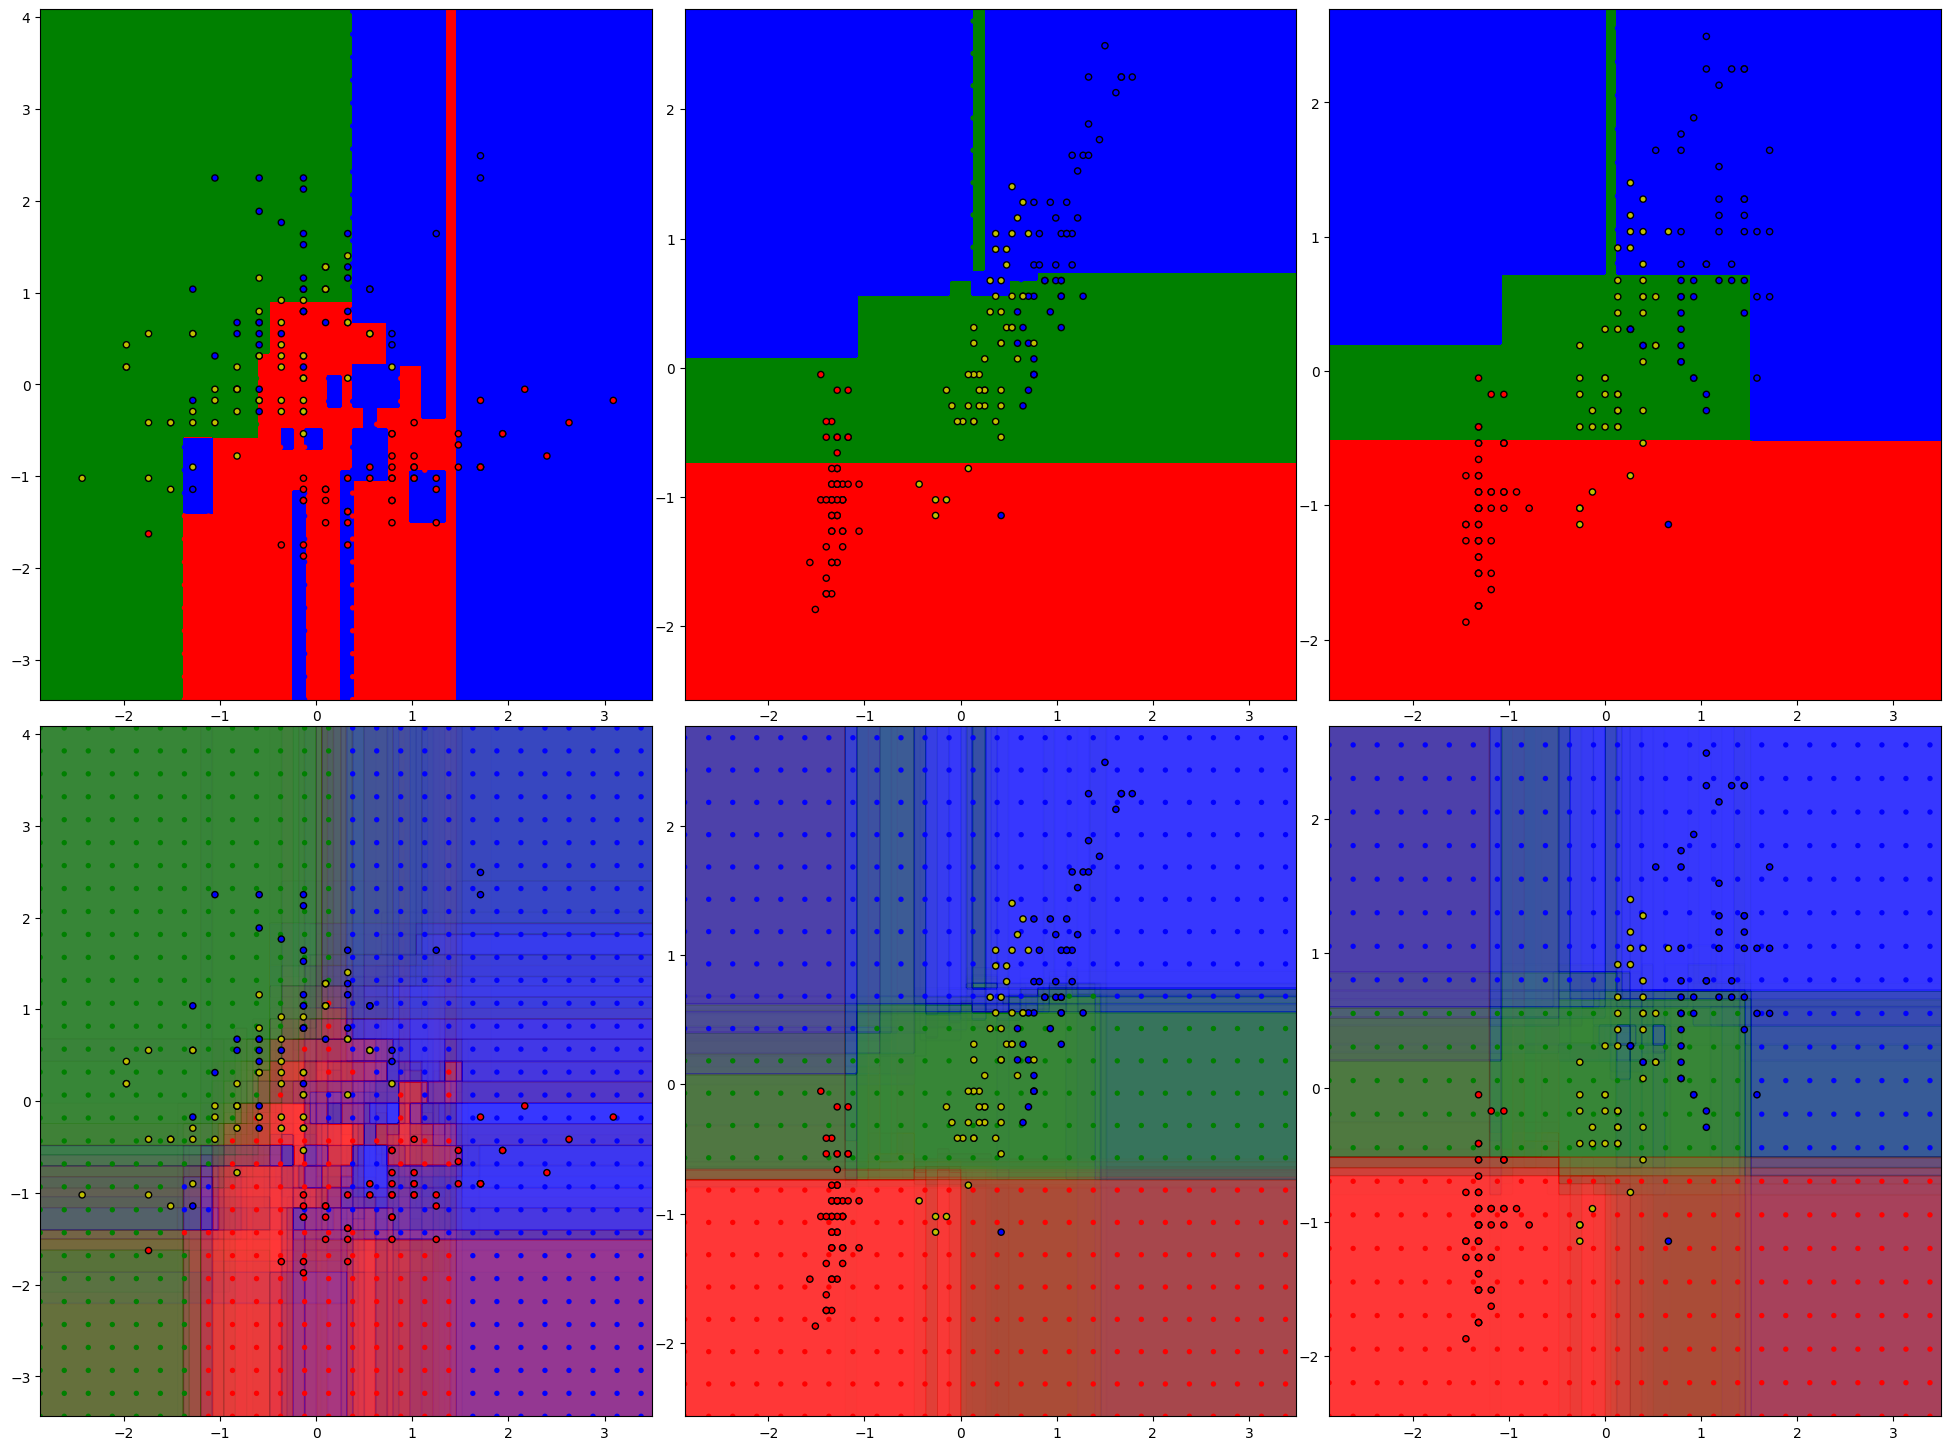

In [3]:
from matplotlib.colors import ListedColormap
from sklearn.datasets import load_iris

# Parameters
n_classes = 3
n_estimators = 100
grb = mpl.colors.ListedColormap(['green', 'red', 'blue'])
rgb = mpl.colors.ListedColormap(['red', 'green', 'blue'])
brg = mpl.colors.ListedColormap(['blue', 'red', 'green'])
cmap = [grb, rgb, rgb]

plot_step = 0.02  # fine step width for decision surface contours
plot_step_coarser = 0.25  # step widths for coarse classifier guesses
RANDOM_SEED = 13  # fix the seed on each iteration

# Load data
iris = load_iris()

plot_idx = 1

models = [DecisionTreeClassifier(max_depth=None),
          RandomForestClassifier(n_estimators=n_estimators)]

for model in models:

    for pair in ([0, 1], [0, 2], [0, 3]):

        color_idx =(plot_idx - 1) % 3

        # We only take the two corresponding features
        X = iris.data[:, pair]
        y = iris.target

        # Shuffle
        idx = np.arange(X.shape[0])
        np.random.seed(RANDOM_SEED)
        np.random.shuffle(idx)
        X = X[idx]
        y = y[idx]

        # Standardize
        mean = X.mean(axis=0)
        std = X.std(axis=0)
        X = (X - mean) / std

        # Train
        model.fit(X, y)

        plt.subplot(2, 3, plot_idx)

        # Now plot the decision boundary using a fine mesh as input to a
        # filled contour plot
        x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
        y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
        xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                             np.arange(y_min, y_max, plot_step))

        # Plot either a single DecisionTreeClassifier or alpha blend the
        # decision surfaces of the ensemble of classifiers
        if isinstance(model, DecisionTreeClassifier):
            Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
            Z = Z.reshape(xx.shape)
            cs = plt.contourf(xx, yy, Z, cmap=cmap[color_idx])
        else:
            # Choose alpha blend level with respect to the number
            # of estimators
            # that are in use (noting that AdaBoost can use fewer estimators
            # than its maximum if it achieves a good enough fit early on)
            estimator_alpha = 1.0 / len(model.estimators_)
            for tree in model.estimators_:
                Z = tree.predict(np.c_[xx.ravel(), yy.ravel()])
                Z = Z.reshape(xx.shape)
                cs = plt.contourf(xx, yy, Z, alpha=estimator_alpha, cmap=cmap[color_idx])

        # Build a coarser grid to plot a set of ensemble classifications
        # to show how these are different to what we see in the decision
        # surfaces. These points are regularly space and do not have a
        # black outline
        xx_coarser, yy_coarser = np.meshgrid(
            np.arange(x_min, x_max, plot_step_coarser),
            np.arange(y_min, y_max, plot_step_coarser))
        Z_points_coarser = model.predict(np.c_[xx_coarser.ravel(),
                                         yy_coarser.ravel()]
                                         ).reshape(xx_coarser.shape)
        cs_points = plt.scatter(xx_coarser, yy_coarser, s=15,
                                c=Z_points_coarser, cmap=cmap[color_idx],
                                edgecolors="none")

        # Plot the training points, these are clustered together and have a black outline
        plt.scatter(X[:, 1], X[:, 0], c=y,
                    cmap=ListedColormap(['r', 'y', 'b']),
                    edgecolor='k', s=20)
        plot_idx += 1  # move on to the next plot in sequence

plt.axis("tight")
plt.tight_layout(h_pad=0.2, w_pad=0.2, pad=2.5)
plt.show()